# Getting Started With Our Analysis

### Loading in the saved dataset and our tools:
So, to get started we're going to pull the pkl file that I saved our last dataset to - the one that we cleaned up and truncated down. It's still a pretty hefty 21K rows, so we've still got plenty to play with this time.

We're basically going to make use of the same tools this time, except we're also going to bring in statsmodels to run quick OLS tests on variations of our final model. Let's get started.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('df_cleaned.csv')
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df['date'] = pd.to_datetime(df.date)
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                float64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

### Check the data for multicolinearity

Before we can move forward with selecting variables, we want to make sure that we deselect those which highly correlate with each other, as they can introduce unnecessary error into our models and interfere with the way we may seek to answer questions.

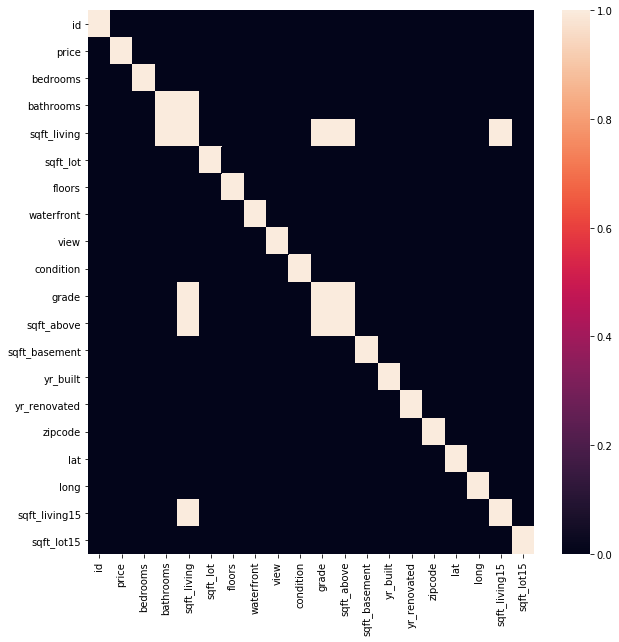

In [5]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr() > 0.75)

From here, we can see that to stay safe, we're going to assume the following features are colinear with each other:

1. `sqft_living` is colinear with `sqft_living15` and `sqft_above`.
2. `sqft_living` is also colinear with `bathrooms` and `grade`.
3. `grade` is colinear with `sqft_above`.

This means that once we are running our model, we want to avoid incorporating `sqft_living` with any of those four fields. However, we could combine some of these features since mostly they only highly correlate with `sqft_living`. I'll illustrate below.

Text(0, 0.5, 'sqft_living15')

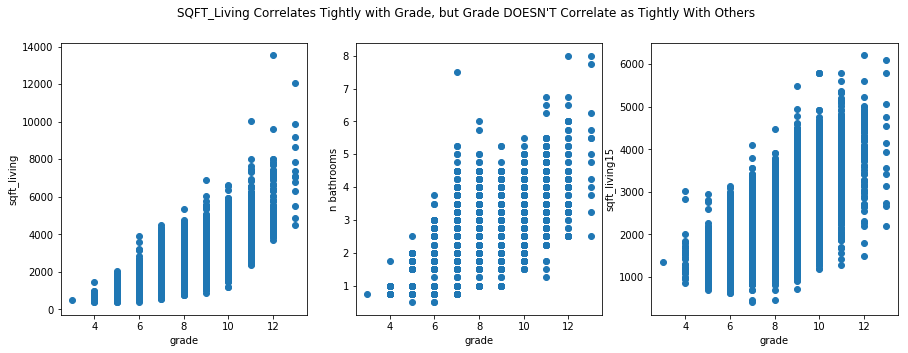

In [6]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("SQFT_Living Correlates Tightly with Grade, but Grade DOESN'T Correlate as Tightly With Others")

ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df.grade, df.sqft_living)
ax1.set_xlabel('grade')
ax1.set_ylabel('sqft_living')

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df.grade, df.bathrooms)
ax2.set_xlabel('grade')
ax2.set_ylabel('n bathrooms')

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df.grade, df.sqft_living15)
ax3.set_xlabel('grade')
ax3.set_ylabel('sqft_living15')

### Check the continuous data for normality

Since we're going to be focused on what's going to work well in predicting price, we want to see how close it is to a standard distribution as-is, and see if maybe we want to normalize it from there. We're just going to take a quick look at a histogram of price and its KDE.

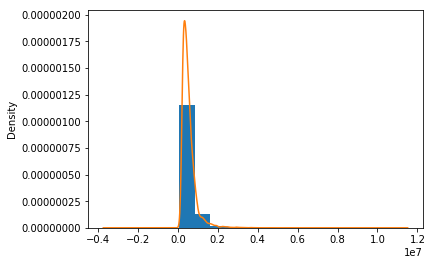

In [7]:
plt.hist(df['price'], density = True)
df['price'].plot.kde()

This is not looking like normally distributed data, so we're going to transform it. Simplest option is always a log transform, as I don't have to load in any extra formulas.

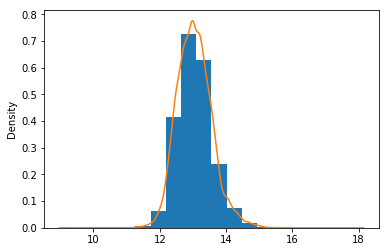

In [8]:
df['pricelog'] = np.log(df['price'])
plt.hist(df['pricelog'], density = True)
df['pricelog'].plot.kde()

Now that `Price` is normally distributed, let's check `sqft_living`.

In [9]:
df['sqft_living'].describe()

count    21054.000000
mean      2082.089864
std        920.578886
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

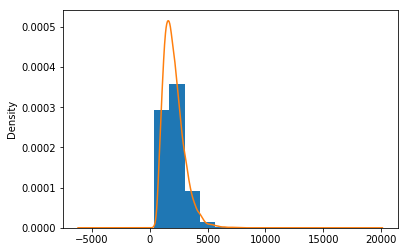

In [10]:
plt.hist(df['sqft_living'], density = True)
df['sqft_living'].plot.kde()

Attempting another log transform on `sqft_living` to see if we can get a more normal distribution out of it as well.

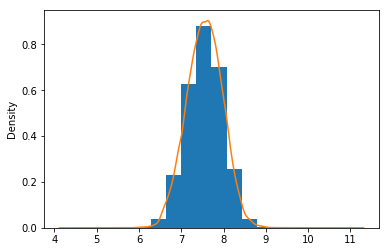

In [11]:
df['sqft_livinglog'] = np.log(df['sqft_living'])
plt.hist(df['sqft_livinglog'], density = True)
df['sqft_livinglog'].plot.kde()

# Answering Meaningful Questions

### What are the main drivers of sale price? Are they controllable?

Now that we've got our dataset normalized and we can understand what corresponds to what, we can start answering questions about our data. To answer what drives sale price, we can take a look at what correlates well with sale price:

In [15]:
Corr = df.corr()
Corr['price'].sort_values(ascending = False)

price             1.000000
pricelog          0.891452
sqft_living       0.702790
grade             0.667369
sqft_livinglog    0.612008
sqft_above        0.605928
sqft_living15     0.584449
bathrooms         0.526757
view              0.393069
sqft_basement     0.322578
bedrooms          0.317586
lat               0.305339
waterfront        0.266549
floors            0.255378
yr_renovated      0.118673
sqft_lot          0.088384
sqft_lot15        0.082992
yr_built          0.053578
condition         0.036172
long              0.021363
id               -0.018183
zipcode          -0.052655
Name: price, dtype: float64

In [13]:
Corr['pricelog'].sort_values(ascending = False)

pricelog          1.000000
price             0.891452
grade             0.703816
sqft_living       0.695856
sqft_livinglog    0.675033
sqft_living15     0.619256
sqft_above        0.602175
bathrooms         0.551478
lat               0.448123
bedrooms          0.352049
view              0.344498
sqft_basement     0.314367
floors            0.309650
waterfront        0.172735
yr_renovated      0.108088
sqft_lot          0.099299
sqft_lot15        0.092602
yr_built          0.080390
long              0.050395
condition         0.038458
id               -0.006103
zipcode          -0.038015
Name: pricelog, dtype: float64

From here we can see that very consistently `price` and `pricelog` correlate closely with `grade` and `sqft_living`. Once we start getting into our models, wen can look a little deeper at how valuable these are as predictors, but it's no surprise based on what we know:  it makes sense that our strongest drivers are total square footage of the floor plan, and a categorical measurement that ranks from 'Cabins' to 'Mansions,' with mansions having higher sale prices.

That is to say, it shouldn't be surprising that the bigger the house, the higher the price; and concurrently, the better the build quality, the higher the price.

As a home builder, these are very controllable:  if a series of lots are acquired and you want to maximize price, you want to maximize the individual square footage allotted to a house; and once you've set on a floor plan, you want to maximize on material and build quality.

#### To test this out, we can try and see what a model would look like if it was made using only `sqft_living` or `grade`.

In [17]:
model_q1a = ols(formula = 'pricelog ~ grade', data=df).fit()
model_q1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 2.066e+04
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:21:14   Log-Likelihood:                -9172.9
No. Observations:               21054   AIC:                         1.835e+04
Df Residuals:                   21052   BIC:                         1.837e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6321      0.017    624.993      0.000      10.599      10.665
grade          0.3156      0.002    143.752      0.000       0.311       0.320
==============================================================================
Omnibus:                      133.048   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.615
Skew:                           0.186   Prob(JB):                     2.16e-30
Kurtosis:                       3.132   Cond. No.                         52.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
model_q1b = ols(formula = 'price ~ sqft_living', data=df).fit()
model_q1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 2.055e+04
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:28:37   Log-Likelihood:            -2.9257e+05
No. Observations:               21054   AIC:                         5.851e+05
Df Residuals:                   21052   BIC:                         5.852e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.515e+04   4471.129    -10.098      0.000   -5.39e+04   -3.64e+04
sqft_living   281.5184      1.964    143.338      0.000     277.669     285.368
==============================================================================
Omnibus:                    14472.352   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           535078.122
Skew:                           2.829   Prob(JB):                         0.00
Kurtosis:                      27.040   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, a model that's based only on `sqft_living` or `grade` can pretty thoroughly explain about half the variation we see in our data - so, it's safe to say that these features are driving price.

### How much do bedrooms, bathrooms, and floors impact sale price?

As a customer, you're usually concerned with the price that you're going to pay, and the number of bed/baths you're going to get. So, to evaluate how much those customer choices drive price, we can take a look again at `df.corr` and then check in with some linear regression modeling

In [20]:
Corr['pricelog'].sort_values(ascending = False)

pricelog          1.000000
price             0.891452
grade             0.703816
sqft_living       0.695856
sqft_livinglog    0.675033
sqft_living15     0.619256
sqft_above        0.602175
bathrooms         0.551478
lat               0.448123
bedrooms          0.352049
view              0.344498
sqft_basement     0.314367
floors            0.309650
waterfront        0.172735
yr_renovated      0.108088
sqft_lot          0.099299
sqft_lot15        0.092602
yr_built          0.080390
long              0.050395
condition         0.038458
id               -0.006103
zipcode          -0.038015
Name: pricelog, dtype: float64

At this point it looks like `bathrooms` could have a pretty big impact, but honestly, with `bedrooms` and `floors` correlating as poorly as they do, it looks like including them might hurt our model, but let's take a look.

In [21]:
model_q2a = ols(formula = 'pricelog ~ bathrooms', data=df).fit()
model_q2a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     9201.
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:52:06   Log-Likelihood:                -12555.
No. Observations:               21054   AIC:                         2.511e+04
Df Residuals:                   21052   BIC:                         2.513e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2501      0.009   1381.983      0.000      12.233      12.268
bathrooms      0.3775      0.004     95.920      0.000       0.370       0.385
==============================================================================
Omnibus:                      188.776   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.682
Skew:                           0.233   Prob(JB):                     8.76e-43
Kurtosis:                       3.058   Cond. No.                         7.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
model_q2b = ols(formula = 'pricelog ~ bathrooms + bedrooms + floors', data=df).fit()
model_q2b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     3171.
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:52:10   Log-Likelihood:                -12447.
No. Observations:               21054   AIC:                         2.490e+04
Df Residuals:                   21050   BIC:                         2.493e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1041      0.013    911.436      0.000      12.078      12.130
bathrooms      0.3268      0.005     61.880      0.000       0.316       0.337
bedrooms       0.0523      0.004     13.230      0.000       0.045       0.060
floors         0.0515      0.007      7.918      0.000       0.039       0.064
==============================================================================
Omnibus:                      192.663   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.773
Skew:                           0.236   Prob(JB):                     1.13e-43
Kurtosis:                       3.054   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This seems to confirm that, just looking at our R-squared values, bathrooms alone explain far less of the model than total square footage - and worse, combining bathrooms with other features like bedrooms and floors doesn't improve the model very much. It's safe to say at this point that building a house meant to maximize on those features won't drive the price very well.

### Where are the new housing developments? What are those units selling for?

Our dataset comes with a `yr_built` feature and also includes `lat` and `long` coordinates, so we should be able to identify newer developments and plot them out versus their peers.

In [58]:
df.groupby('yr_built').count().tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog
yr_built,,,,,,,,,,,,,,,,,,,,,
2011,127,127,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127
2012,163,163,163,163,163,163,163,163,163,163,...,163,163,163,163,163,163,163,163,163,163
2013,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
2014,547,547,547,547,547,547,547,547,547,547,...,547,547,547,547,547,547,547,547,547,547
2015,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35


In [59]:
recent_builds = df.loc[df['yr_built'] >= 2014]
recent_builds.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog
40,7203220400,2014-07-07,861990.0,5.0,2.75,3595,5639,2.0,0.0,0.0,...,0.0,2014,0.0,98053,47.6848,-122.016,3625,5639,13.666999,8.187299
61,9528102996,2014-12-07,549000.0,3.0,1.75,1540,1044,3.0,0.0,0.0,...,0.0,2014,0.0,98115,47.6765,-122.320,1580,3090,13.215854,7.339538
129,8929000270,2014-05-12,453246.0,3.0,2.50,2010,2287,2.0,0.0,0.0,...,620.0,2014,0.0,98029,47.5517,-121.998,1690,1662,13.024190,7.605890
135,2767603505,2014-05-07,519950.0,3.0,2.25,1170,1249,3.0,0.0,0.0,...,0.0,2014,0.0,98107,47.6722,-122.381,1350,1310,13.161488,7.064759
205,1025049114,2014-07-17,625504.0,3.0,2.25,1270,1566,2.0,0.0,0.0,...,210.0,2014,0.0,98105,47.6647,-122.284,1160,1327,13.346313,7.146772


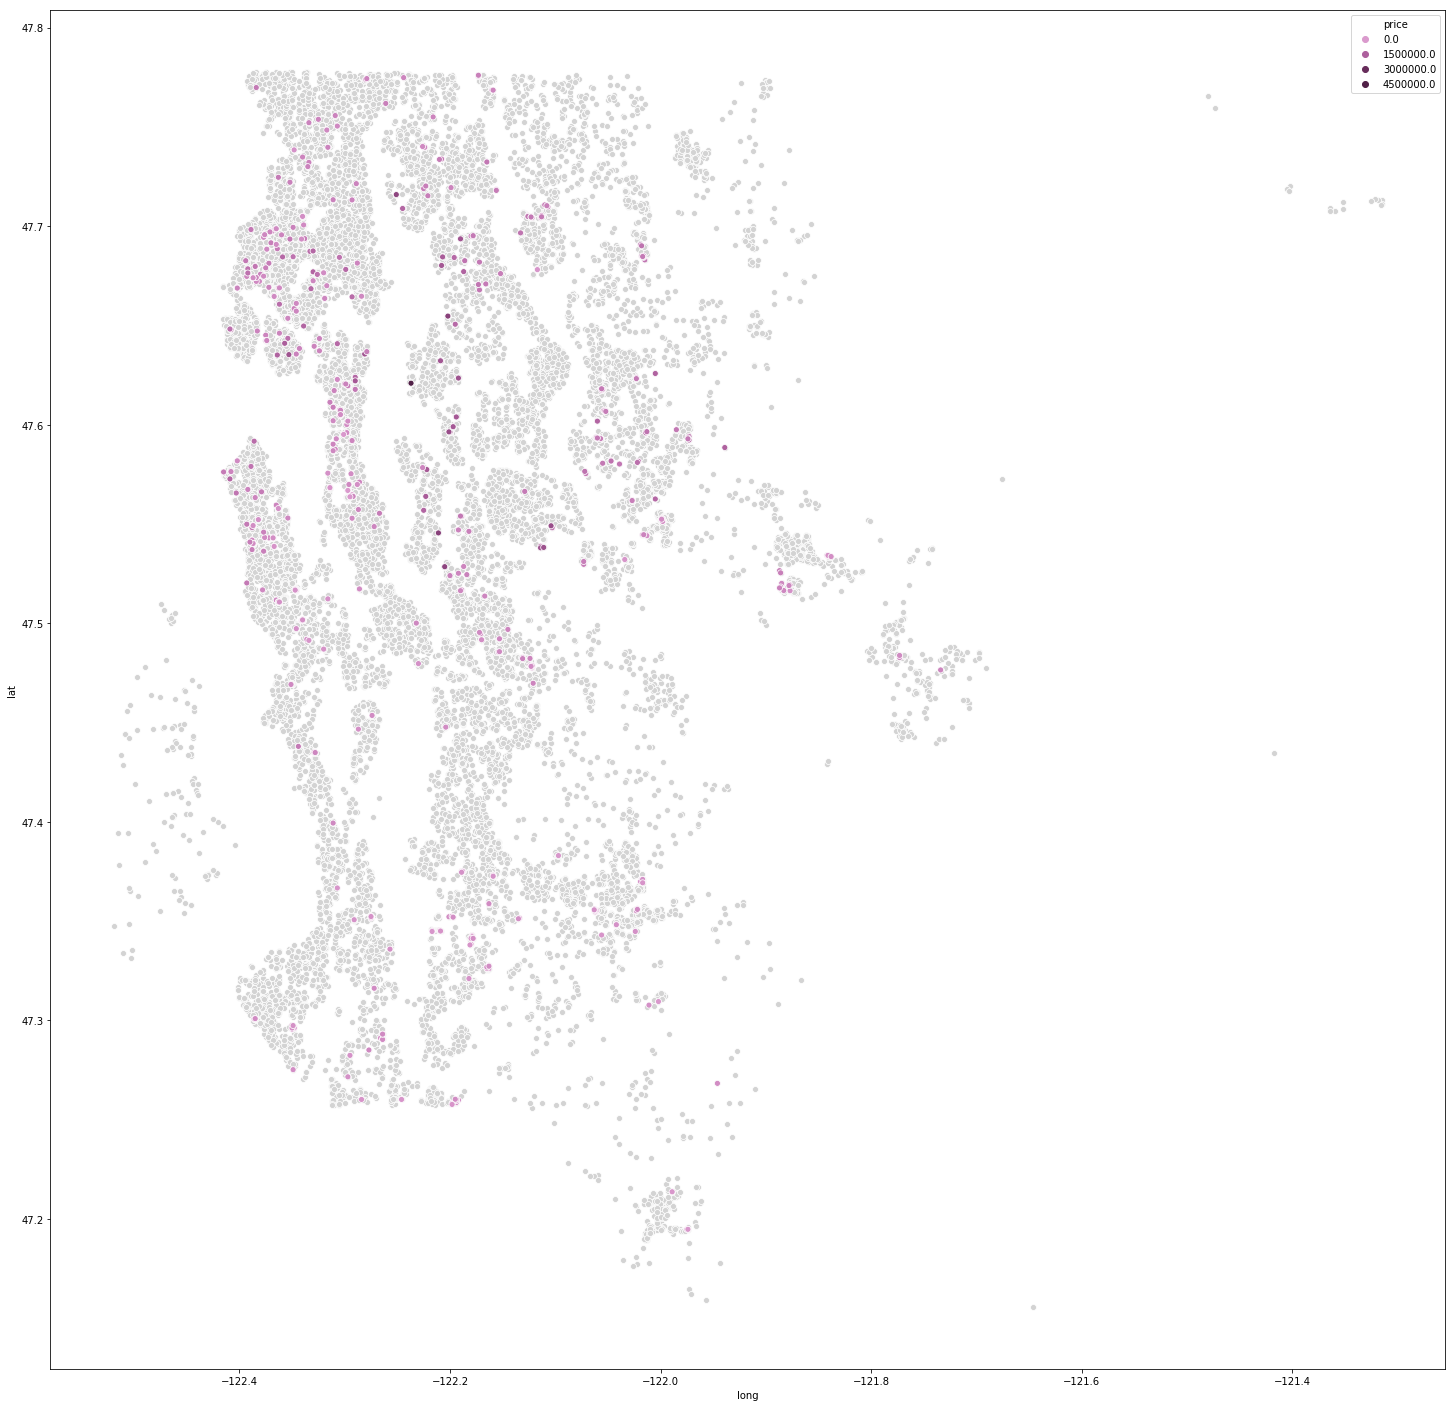

In [141]:
fig = plt.figure(figsize=(25,25))

sns.scatterplot(x=df.long, y=df.lat, color = 'lightgrey')
sns.scatterplot(x=recent_builds.long, y=recent_builds.lat, hue=recent_builds['price'],
                palette = "ch:0.5,h=1,r=0,l=0.7,d=.2")

In [123]:
recent_builds['price'].describe()

count    5.820000e+02
mean     6.876867e+05
std      3.803609e+05
min      1.750030e+05
25%      4.299840e+05
50%      5.990000e+05
75%      8.399800e+05
max      3.420000e+06
Name: price, dtype: float64

So, from here we can plainly see that a lot of the growth in new housing is just north of Seattle. There's definitely some interspersed development, but we can see it really clustering close to the city center and just north of it. By using some descriptive statistics we can see that the minimum a new house sells for is 175K, while the median house price is 599K.

We can also see that some of the very expensive houses are clustered on that island just west of Seattle.

# -Incomplete past this point-

In [27]:
model5 = ols(formula = 'pricelog ~ sqft_livinglog + lat + condition + grade + waterfront + view + yr_built', data=df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     9266.
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -1565.8
No. Observations:               21054   AIC:                             3148.
Df Residuals:                   21046   BIC:                             3211.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -51.7693      0.692    -74.758      0.000     -53.127     -50.412
sqft_livinglog     0.4427      0.006     69.074      0.000       0.430       0.455
lat                1.3748      0.013    101.960      0.000       1.348       1.401
condition          0.0521      0.003     17.458      0.000       0.046       0.058
grade              0.2002      0.002     80.695      0.000       0.195       0.205
waterfront         0.4127      0.023     17.579      0.000       0.367       0.459
view               0.0737      0.003     27.467      0.000       0.068       0.079
yr_built          -0.0029   7.62e-05    -37.570      0.000      -0.003      -0.003
==============================================================================
Omnibus:                      392.056   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.299
Skew:                           0.147   Prob(JB):                    7.70e-151
Kurtosis:                       3.838   Cond. No.                     7.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like the model works fine without longitude. This is likely because at this point we have more factors that are playing a stronger role in determination than longitude itself was.

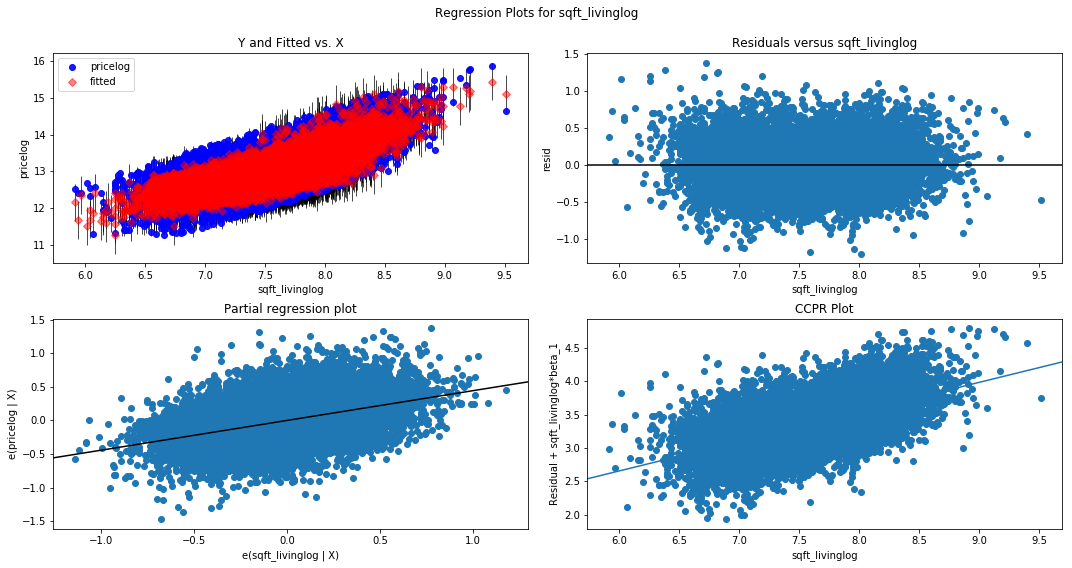

In [28]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model5, "sqft_livinglog", fig=fig)
plt.show()

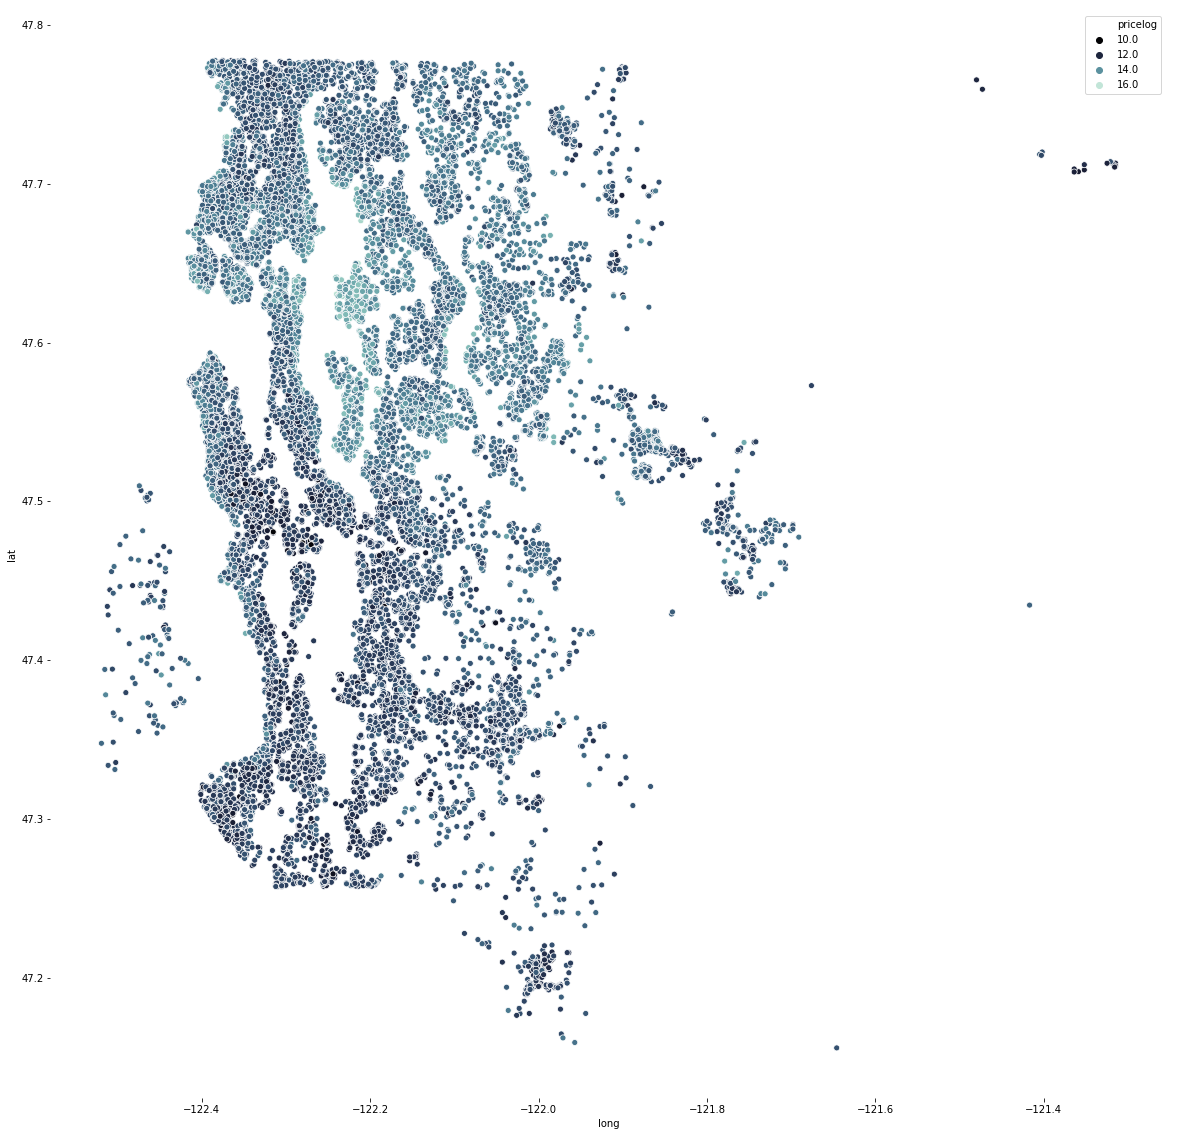

In [55]:
f, ax = plt.subplots(figsize=(20, 20))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="long", y="lat",
                hue="pricelog",
                palette="ch:r=-.3,d=0.01_r",
                data=df, ax=ax)

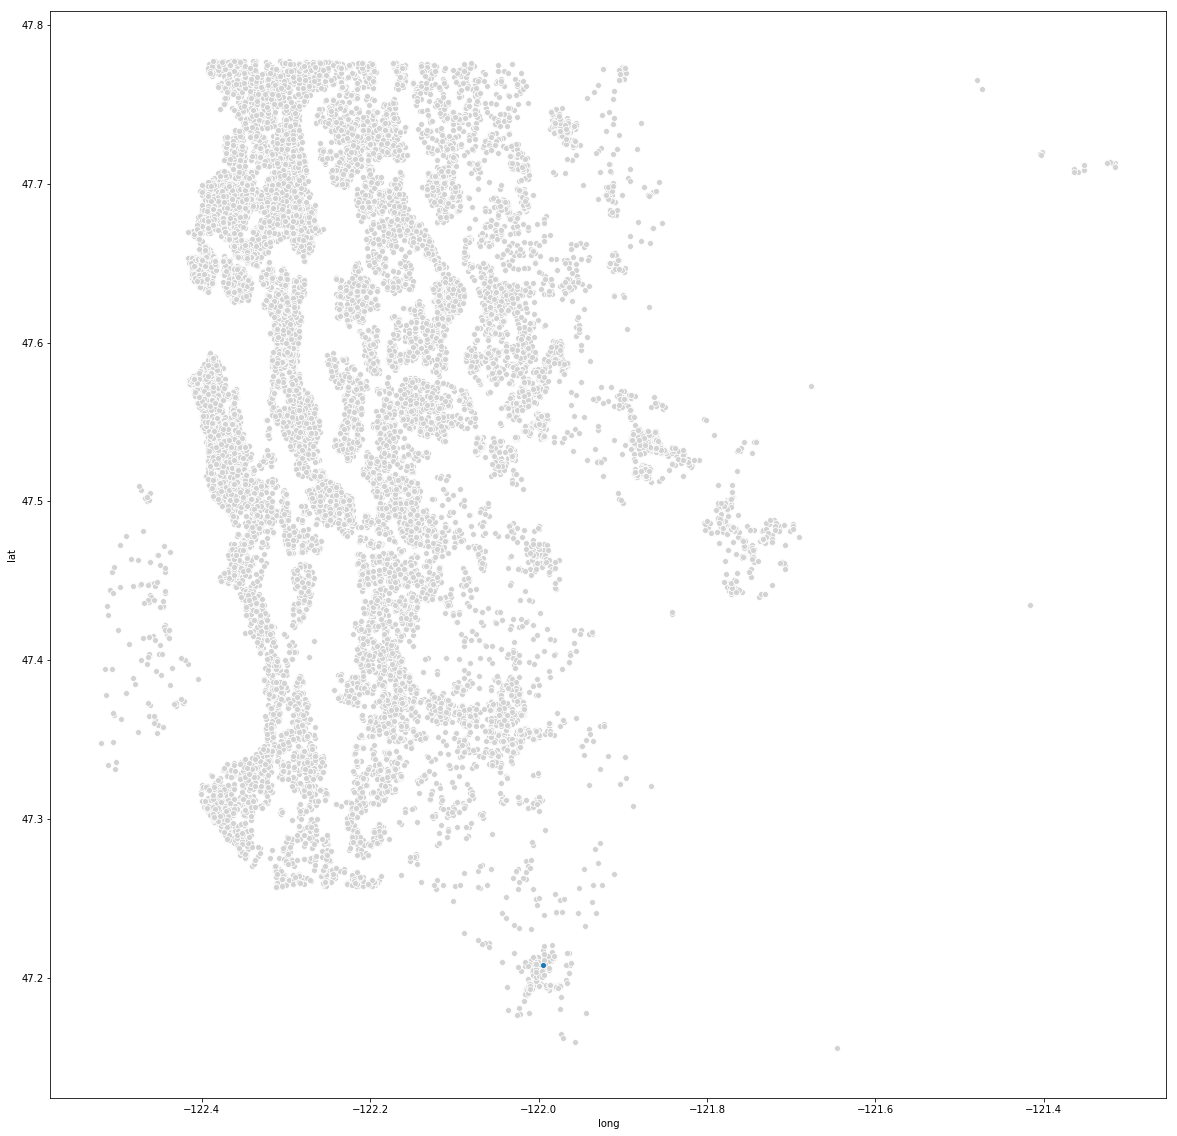

In [147]:
cabins = df.loc[df['grade'] <= 3]

fig = plt.figure(figsize=(20,20))
sns.scatterplot(x=df.long, y=df.lat, color='lightgrey')
sns.scatterplot(x=cabins.long, y=cabins.lat)

In [146]:
df.grade.value_counts()

7     8722
8     5921
9     2556
6     1993
10    1110
11     390
5      234
12      87
4       27
13      13
3        1
Name: grade, dtype: int64

In [148]:
cabins

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog
3142,2420069251,2015-02-25,262000.0,1.0,0.75,520,12981,1.0,0.0,0.0,...,0.0,1920,0.0,98022,47.2082,-121.995,1340,12233,12.4761,6.253829
